# Mask detection system
**Hind Baageel**

*in this project, we implmented a mask detection system with the help of open cv library*

*The system work by first detecting faces in a an image or a video, then uses deep learning to detect if the person wears mask or not.*

code were taken from **Hussain Mujtaba** 

https://www.mygreatlearning.com/blog/real-time-face-detection/

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2] # OS.path.sep split the path names into a list and -2 takes the second before last folder name
        
        
        # load the input image (224x224) and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
        
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [38]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
        layer.trainable = False

In [39]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
        test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [40]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
        aug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 8s 244ms/step - loss: 0.3348 - accuracy: 0.8502 - val_loss: 0.0962 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 7s 201ms/step - loss: 0.1138 - accuracy: 0.9672 - val_loss: 0.0492 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 7s 201ms/step - loss: 0.0655 - accuracy: 0.9822 - val_loss: 0.0339 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 7s 201ms/step - loss: 0.0580 - accuracy: 0.9822 - val_loss: 0.0259 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 7s 201ms/step - loss: 0.0355 - accuracy: 0.9925 - val_loss: 0.0208 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 7s 201ms/step - loss: 0.0253 - accuracy: 0.9944 - val_loss: 0.0181 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 7s 203ms/step - loss: 0.0283 - accuracy: 0.993

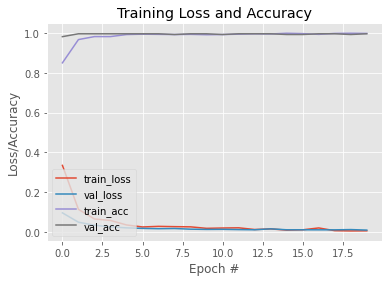

In [42]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [47]:
#To save the trained model
model.save('mask_recog_ver2.h5')

### *Now the Deep Learning model has been trained sucessfully and ready to be used as a predictor.*

#### *we will use the saved DL model to predict if a person wears a mask or not in a static image.*

In [1]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

In [2]:
#using the pre-trained harrcascade face detection model available in Open CV library
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Loading the pre-trained DL model
model = load_model('mask_recog_ver2.h5')

In [3]:
#Loading the image

image = cv2.imread("19.jpg")

#harrcascade detection model only works on grey images, so we need to convert the image into gray

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#faces is a list of the detected faces' locations
faces = faceCascade.detectMultiScale(gray,1.1,5)

In [4]:
faces_list=[]

preds=[]

for (x, y, w, h) in faces:
    face_frame = image[y:y+h,x:x+w]
    face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
    face_frame = cv2.resize(face_frame, (224, 224))
    face_frame = img_to_array(face_frame)
    face_frame = np.expand_dims(face_frame, axis=0)
    face_frame =  preprocess_input(face_frame)
    faces_list.append(face_frame)
    
    if len(faces_list)>0:
        preds = model.predict(faces_list)
        
    for pred in preds:
    #mask contain Probability of wearing a mask and vice versa
         (mask, withoutMask) = pred 

### *Now after we calculated the probability of wearing a mask, we will show the final label in top of the static image using a colored rectangele. red rectangle for (no mask label) and green rectangle for (mask label)*

In [7]:
label = "Mask" if mask > withoutMask else "No Mask"

color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)


cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

cv2.rectangle(image, (x, y), (x + w, y + h),color, 2)

array([[[248, 250, 250],
        [248, 250, 250],
        [248, 250, 250],
        ...,
        [249, 251, 251],
        [249, 251, 251],
        [249, 251, 251]],

       [[248, 250, 250],
        [248, 250, 250],
        [248, 250, 250],
        ...,
        [249, 251, 251],
        [249, 251, 251],
        [249, 251, 251]],

       [[248, 250, 250],
        [248, 250, 250],
        [248, 250, 250],
        ...,
        [249, 251, 251],
        [249, 251, 251],
        [249, 251, 251]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 20,  22,  22],
        [ 19,  21,  21],
        [ 18,  20,  20]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 20,  22,  22],
        [ 19,  21,  21],
        [ 18,  20,  20]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 20,  22,  22],
        [ 19,  21,  21],
        [ 18,  20,  20]]

In [8]:
cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Detecting Masks in Videos

In [30]:
import numpy as np

cap = cv2.VideoCapture('C:\\Users\\hinda\\Mask detector system\\video2.mp4') #for webcam, just replace the file path with 0. 

if cap.isOpened(): # try to get the first frame
    rval, frame = cap.read()

else:
    rval = False

while rval: 
    
    faces_list=[]
    preds=[]
    
    for (x, y, w, h) in faces:
        
        face_frame = frame[y:y+h,x:x+w]
        
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        
        face_frame = cv2.resize(face_frame, (224, 224))
        
        face_frame = img_to_array(face_frame)
        
        face_frame = np.expand_dims(face_frame, axis=0)
        
        face_frame =  preprocess_input(face_frame)
        
        faces_list.append(face_frame)
        
        if len(faces_list)>0:
            
            preds = model.predict(faces_list)
            
        for pred in preds:
            
            (mask, withoutMask) = pred
            
        label = "Mask" if mask > withoutMask else "No Mask"
        
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        
        cv2.putText(frame, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
 
        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
    


    #cv2.resizeWindow("Mask video", 20, 20) # resizing the window

    cv2.moveWindow("Mask video", 1, 1) #moving the window to the corner of the screen

    cv2.imshow("Mask video", frame) #show the frames one by one

    rval, frame = cap.read()

    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

cv2.destroyWindow("Mask video")